


### Assignment 1
----
COMP 7745 Machine Learning <br><br>
Univerity of Memphis <br>
Fall 2022 <br>

@author <br>
Bereket Kebede <br>

### Linear Regression
----

[Ref] <br>
https://github.com/hunkim/KaggleZeroToAll/blob/master/k0-03-house-prices-advanced-regression-techniques/k0-03-house-prices-advanced-regression-techniques.ipynb

In [32]:
# code to downlaod and load 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics

from scipy.stats import skew

#tf.set_random_seed(777)  # for reproducibility

%matplotlib inline

In [2]:
def scatter(data, var):
    matplotlib.rcParams['figure.figsize'] = (12.0, 4.0)
    data = pd.concat([data['SalePrice'], data[var]], axis=1)
    data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [3]:
data = pd.read_csv("train.csv")

array([[<AxesSubplot: title={'center': 'log(price + 1)'}>,
        <AxesSubplot: title={'center': 'price'}>]], dtype=object)

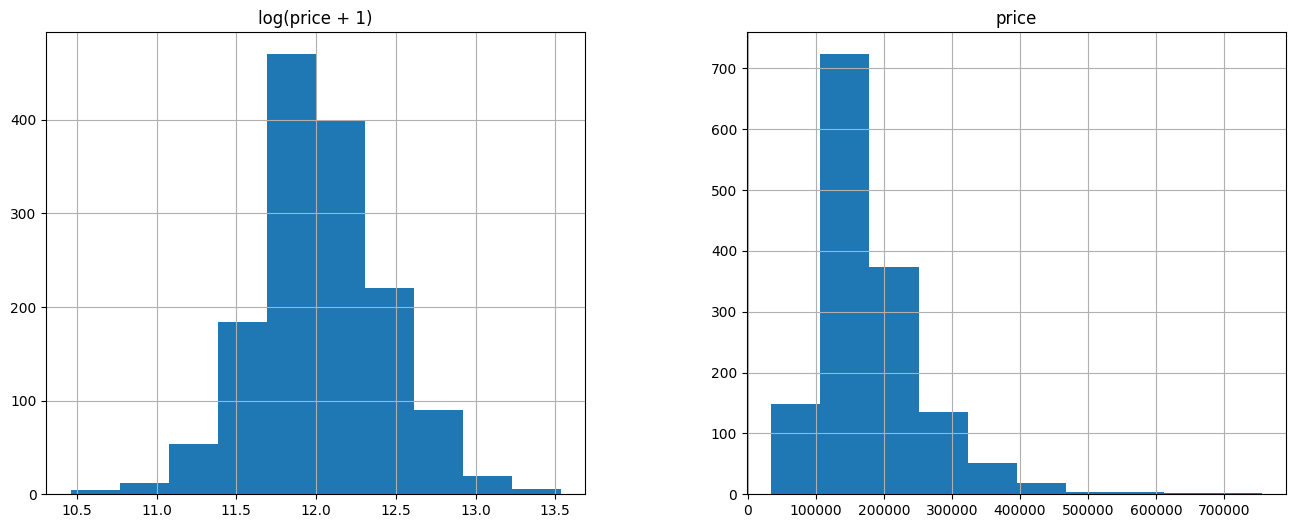

In [4]:
matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)
prices = pd.DataFrame({"log(price + 1)":np.log1p(data["SalePrice"]), "price":data["SalePrice"]})
prices.hist()

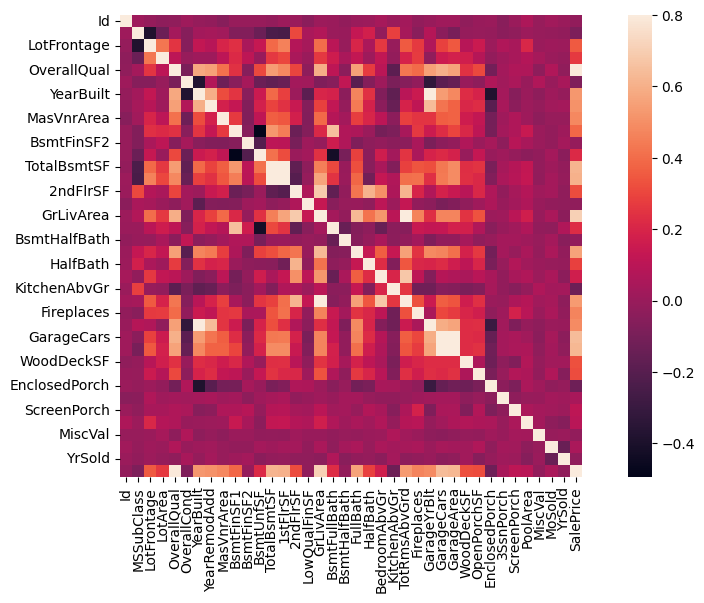

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
corrmat = data.corr()
sns.heatmap(corrmat, vmax=.8, square=True);

C:\Users\Berek\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


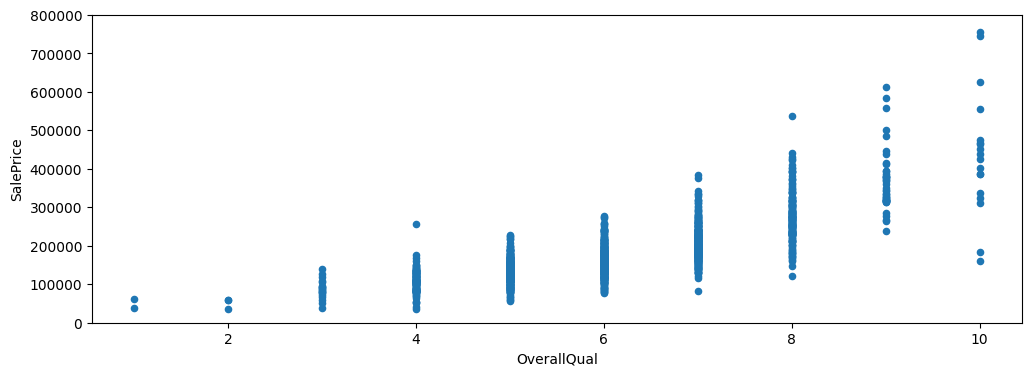

In [6]:
scatter(data, 'OverallQual')

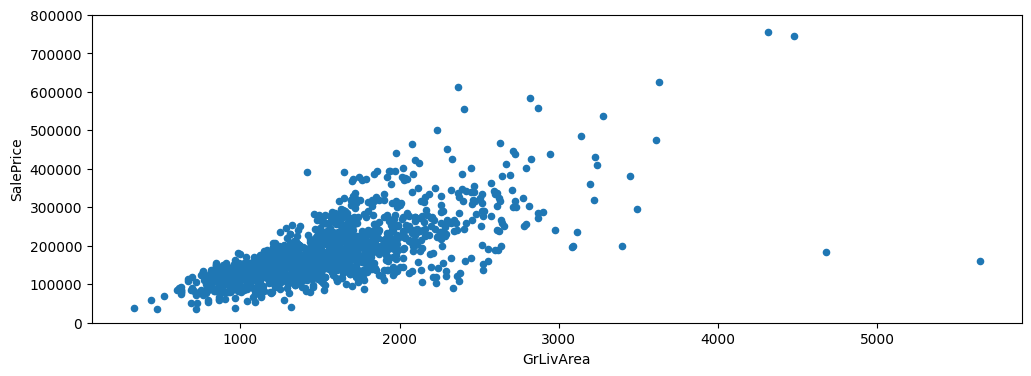

In [7]:
scatter(data, 'GrLivArea')

In [8]:
def load_file(is_test=False):
    test = pd.read_csv("test.csv")
    train = pd.read_csv("train.csv")
    
    cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
        
    data_df = pd.concat((train.loc[:, cols],
                         test.loc[:, cols]))

    numeric_feats = data_df.dtypes[data_df.dtypes != 'object'].index
    skewed_feats = data_df[numeric_feats].apply(lambda x: skew(x.dropna())) 
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index

    data_df[skewed_feats] = np.log1p(data_df[skewed_feats])
    data_df = pd.get_dummies(data_df)
    data_df = data_df.fillna(data_df.mean())
        
    return data_df, train, test

In [9]:
all_data, train, test = load_file()
x_train = all_data[:train.shape[0]]
x_test = all_data[train.shape[0]:]
y_train = np.expand_dims(np.log1p(train.SalePrice), axis=1)

print(x_train.shape, y_train.shape)

(1460, 6) (1460, 1)


In [10]:
all_data.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
0,7,7.444833,2.0,6.753438,2,2003
1,6,7.141245,2.0,7.141245,2,1976
2,7,7.488294,2.0,6.825460,2,2001
3,7,7.448916,3.0,6.629363,1,1915
4,8,7.695758,3.0,7.044033,2,2000


In [12]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [13]:
# Parameters
learning_rate = 0.001

# Network Parameters
n_input = x_train.shape[1]

# placeholders for a tensor that will be always fed.
X = tf.placeholder(tf.float32, shape=[None, n_input])
Y = tf.placeholder(tf.float32, shape=[None, 1])

W = tf.Variable(tf.random_normal([n_input, 1]), name='weight')
b = tf.Variable(tf.random_normal([1]), name='bias')

hypothesis = tf.matmul(X, W) + b

# cost/loss function
cost = tf.reduce_mean(tf.square(hypothesis- Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# TODO: Accuracy computation

In [14]:
training_epochs = 2001
step_size=50

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training cycle
for epoch in range(training_epochs):
    
    avg_cost = 0 
    for step in range(0, len(x_train), step_size):
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: x_train[step:step+step_size], 
                                                      Y: y_train[step:step+step_size]})
        avg_cost += c
    
    avg_cost = avg_cost / len(x_train)

    if epoch % 250 == 0 :
        print("epoch: {} cost: {:.4f}".format(epoch, avg_cost))
        
print("Optimization Finished!")

epoch: 0 cost: 97511.5408
epoch: 250 cost: 0.2356
epoch: 500 cost: 0.0555
epoch: 750 cost: 0.0052
epoch: 1000 cost: 0.0028
epoch: 1250 cost: 0.0014
epoch: 1500 cost: 0.0009
epoch: 1750 cost: 0.0008
epoch: 2000 cost: 0.0008
Optimization Finished!


In [15]:
# inverse of the log1p is expm1
test_price = np.squeeze(np.expm1(sess.run(hypothesis, feed_dict={X: x_test})), axis=(1,)) 
train_price = np.squeeze(np.expm1(sess.run(hypothesis, feed_dict={X: x_train})), axis=(1,))

In [21]:
matplotlib.rcParams['figure.figsize'] = (14.0, 6.0)
price=train["SalePrice"]

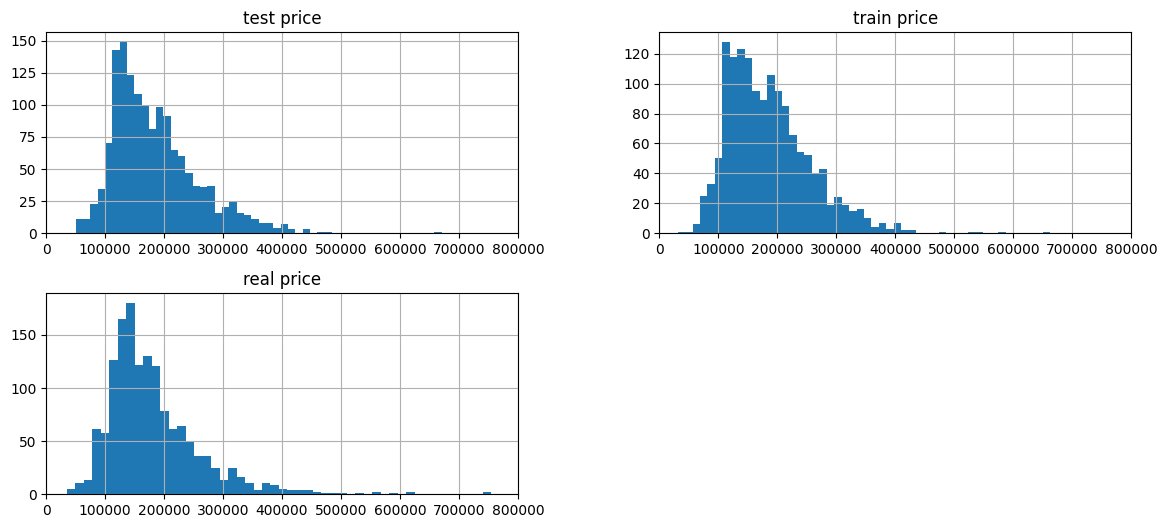

In [22]:
test_tmp = np.concatenate((test_price[:], test_price[0:1])) # for match shape

prices = pd.DataFrame({"test price": test_tmp, "train price":train_price, "real price":price})

for array in prices.hist(bins=50):
    for subplot in array:
        subplot.set_xlim((0, 800000))

In [33]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('__________________________________')

In [34]:
print_evaluate(price, test_tmp)

MAE: 79489.38930864727
MSE: 11379036010.157873
RMSE: 106672.56446789809
__________________________________


In [18]:
ids = pd.read_csv("test.csv").Id
submission = ['Id,SalePrice']

for id, prediction in zip(ids, test_price):
    submission.append('{0},{1}'.format(id, prediction))

submission = '\n'.join(submission)

with open('submission.csv', 'w') as outfile:
    outfile.write(submission)